In [1]:
# import utils
from typing import Any
import torch as t
import torch.nn.functional as F
import numpy as np
import itertools
import matplotlib.pyplot as plt
import torch
# from functools import partial
%matplotlib inline

In [2]:
# parameters for top-k distribution
rng = np.random.RandomState(1234)
n = 10
k = 1

In [3]:
# generate random parameters for the distribution: these are the initial weights
theta = rng.randn(n)
print(theta)

[ 0.47143516 -1.19097569  1.43270697 -0.3126519  -0.72058873  0.88716294
  0.85958841 -0.6365235   0.01569637 -2.24268495]


In [4]:
# create all possible_states:
combs = list(itertools.combinations(range(n), k))
n_states = len(combs)
assert n_states == np.math.factorial(n)/(np.math.factorial(k)*np.math.factorial(n-k))
print('Number of possible states:', n_states)
mat_x = np.zeros((len(combs), n))
for i in range(n_states):
    mat_x[i, combs[i]] = 1.

print(mat_x)

Number of possible states: 10
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [5]:
# put all of this in pytorch
theta_t = t.from_numpy(theta).float().requires_grad_(True)
states_t = t.from_numpy(mat_x).float()

def tow_t(_theta):
    return states_t @ _theta

def Z_t(_theta):
    return t.log(t.sum(t.exp(tow_t(_theta))))

def pmf_t(_theta):
    return t.exp(tow_t(_theta) - Z_t(_theta))

def sample_state_from_pdf(_theta):
    _pmft = pmf_t(_theta)
    indx_ch = rng.choice(list(range(n_states)), p=_pmft.detach().numpy())
    return indx_ch

In [6]:
print(t.sum(pmf_t(theta)))  # so far so good

tensor(1., dtype=torch.float64)


In [7]:
#groundtruth distribution
b_t = t.abs(t.from_numpy(rng.randn(n)).float())

In [8]:
print(b_t)

tensor([1.1500, 0.9919, 0.9533, 2.0213, 0.3341, 0.0021, 0.4055, 0.2891, 1.3212,
        1.5469])


In [9]:
sorted_bt = np.sort(b_t.detach().numpy())
min_value_of_exp = np.sum((sorted_bt[:5])**2) + np.sum((sorted_bt[5:] - 1)**2)
print(min_value_of_exp)

2.7361908


In [10]:
def objective(index):
    return t.sum((states_t[index] - b_t)**2)

objective(1)

tensor(10.8149)

In [11]:
b_t

tensor([1.1500, 0.9919, 0.9533, 2.0213, 0.3341, 0.0021, 0.4055, 0.2891, 1.3212,
        1.5469])

In [12]:
len(pmf_t(theta_t))

10

In [13]:
# writing explicitly the expectation of this objective summing over
# all possible states:
def expectation_t(_theta):
    _pmf = pmf_t(_theta)
    _p_values = t.stack([_pmf[i] * objective(i) for i in range(n_states)])
    return t.sum(_p_values)

In [14]:
expectation_t(theta_t)

tensor(11.2864, grad_fn=<SumBackward0>)

In [15]:
#Ground truth gradient
exact_gradient = t.autograd.grad(expectation_t(theta_t), theta_t)

Essentially we are now solving explicitly
$\min_{\theta} \mathbb{E}_{z\sim p(z, \theta)} b^\intercal z$
where $p(z, \theta)$ is top-k distribution.

With full optimization we simply write $\mathbb{E}_{z\sim p(z, \theta)} b^\intercal z= \sum_{i=1}^{N} p(z_i, \theta) b^\intercal z_i $
summing over all possible states, where $N=\binom{n}{k}$


In [16]:
def return_grad(strategy, reinitialize=True):
    global theta_t
    if reinitialize:
        theta_t = t.from_numpy(theta).float().requires_grad_(True)
        
    # redefine objective with given strategy
    def objective_(_theta):
        sample = strategy(_theta)
#         print("Sample from obj_", sample)
#         import pdb; pdb.set_trace()
#         return t.sum((sample - b_t)**2)
        if len(sample.shape) == 2:
            return ((sample - b_t)**2).mean(dim=0).sum()
        else:
            return t.sum((sample - b_t)**2)
        
    obj = objective_(theta_t)
    obj.backward()
    return theta_t.grad

In [17]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    return -Variable(torch.log(-torch.log(U + eps) + eps))

def gumbel_softmax_sample(logits, temperature):
#     import pdb; pdb.set_trace()
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature=1.0):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y

grads = []
for i in range(10000):
    grads += [return_grad(gumbel_softmax)]
STGS_grads = torch.stack(grads)

In [18]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

def SIMPLE(logits):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = F.softmax(logits, dim=-1)
    y_perturbed = F.softmax(logits + sample_gumbel(logits.size()))
    shape = y.size()
    _, ind = y_perturbed.max(dim=-1)
    y_hard = torch.zeros_like(y_perturbed).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y

grads = []
for i in range(10000):
    grads += [return_grad(SIMPLE)]
SIMPLE_grads = torch.stack(grads)

/tmp/ipykernel_2149684/1349740020.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_perturbed = F.softmax(logits + sample_gumbel(logits.size()))


In [19]:
exact_gradient = exact_gradient[0].expand(10000, 10)

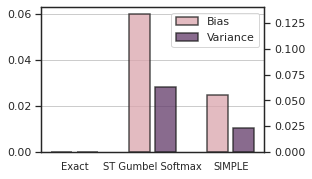

In [54]:
import math
import seaborn as sns
sns.set_theme(style="white")

sanae_colors = [sns.cubehelix_palette(as_cmap=False)[i] for i in range(6)]

gradients = {'Exact': exact_gradient, 'ST Gumbel Softmax': STGS_grads, 'SIMPLE':SIMPLE_grads}
x = ['Exact', 'ST Gumbel Softmax', 'SIMPLE']
x_axis = np.arange(len(x))

bias = [1.0 - F.cosine_similarity(exact_gradient.mean(axis=0), gradients[estimator].mean(axis=0), dim=0) for estimator in x]

fig, ax1 = plt.subplots(figsize=(4, 2.67));
lns1 = ax1.bar(x=[0, 3, 6], height=bias, alpha=0.75, edgecolor="k", lw=1.5, color=sanae_colors[1], label='Bias')
ax1.grid(axis="y")
plt.xticks([0.5, 3.5, 6.5], x, fontsize=10)


ax2=plt.twinx()

variance = []
for estimator in x:
    mu = gradients[estimator].mean(axis=0)
    variance += [(1.0 - F.cosine_similarity(gradients[estimator], mu)).var()]

lns3 = ax2.bar(x=[1, 4, 7], height=variance, alpha=0.75, edgecolor="k", lw=1.5, color=sanae_colors[4], label='Variance')

ax2.set_ylim([0.0, 0.14])
plt.legend([lns1, lns3], ['Bias', 'Variance'],loc=1)

plt.savefig('bias_variance_SIMPLE_STGS.pdf',bbox_inches='tight')
plt.show()